In [1]:
from pathlib import Path

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import scienceplots
import seaborn as sns
import statsmodels
from jax import lax

sns.set_style("whitegrid")

In [53]:
df = pl.read_parquet("../data/results/PFE/result_mix.parquet")

In [54]:
df = df.with_columns([(pl.col("ts_event") / 1e9).alias("ts_sec")])
df = df.with_columns([pl.col("ts_sec").diff().fill_null(0).alias("dt")])

In [55]:
def ou_path(dt, kappa, sigma, key):
    decay = jnp.exp(-kappa * dt)
    std = sigma * jnp.sqrt((1 - jnp.exp(-2 * kappa * dt)) / (2 * kappa))
    Z = jax.random.normal(key, shape=dt.shape)
    innovations = std * Z

    def step(X, inp):
        d, innov = inp
        X_new = d * X + innov
        return X_new, X_new

    _, X_exo = lax.scan(step, 0.0, (decay, innovations))
    return X_exo

In [56]:
imb = df["imb"].to_numpy()
var_imb = np.var(imb)
std_imb = np.std(imb)

kappa = 1.0
sigma = std_imb * np.sqrt(2 * kappa)

key = jax.random.PRNGKey(0)
dt = jnp.array(df["dt"].to_numpy())
X_exo = ou_path(dt, kappa=1.0, sigma=0.5, key=key)

w1, w2 = 1.0, 1.0
alpha = w1 * imb + w2 * X_exo
kappa, sigma

(1.0, 0.7219765349617068)

In [57]:
df = df.with_columns(noise=np.asarray(X_exo), alpha=np.asarray(alpha))

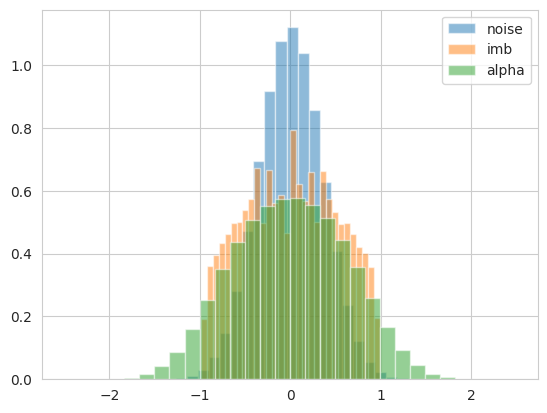

In [21]:
plt.hist(df["noise"], bins=30, density=True, label="noise", alpha=0.5)
plt.hist(df["imb"], bins=30, density=True, label="imb", alpha=0.5)
plt.hist(df["alpha"], bins=30, density=True, label="alpha", alpha=0.5)

plt.legend()
plt.show()

mean(α): 0.0001
std(α): 0.5774
mean(|α|): 0.4453
|α| 50th percentile: 0.3600
|α| 75th percentile: 0.6118
|α| 85th percentile: 0.8010
|α| 90th percentile: 0.9282
|α| 95th percentile: 1.1925
mean(α | imb > 0): 0.1842
mean(α | imb < 0): -0.1782


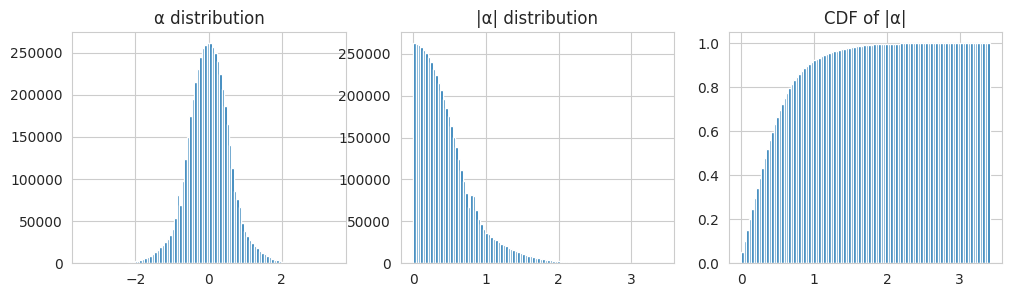

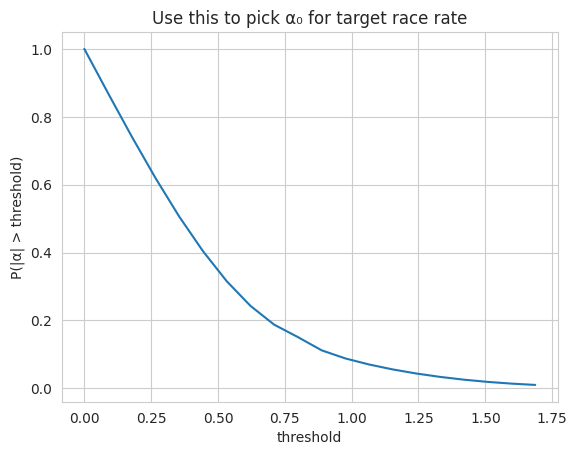

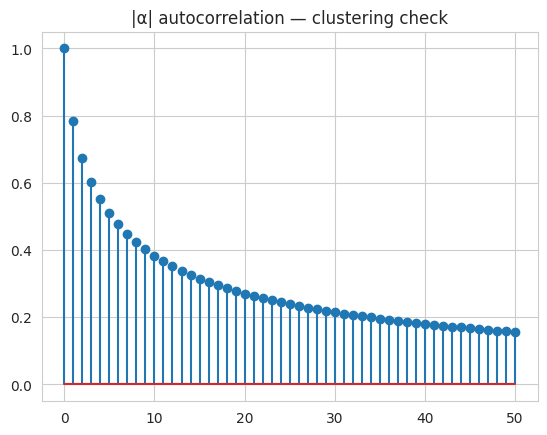

In [72]:
imb = df["imb"].to_numpy()
alpha = df["alpha"].to_numpy()
alpha_abs = np.abs(alpha)

# 1. Basic stats
print(f"mean(α): {np.mean(alpha):.4f}")
print(f"std(α): {np.std(alpha):.4f}")
print(f"mean(|α|): {np.mean(alpha_abs):.4f}")

# 2. Quantiles of |α| — directly gives threshold candidates
for q in [50, 75, 85, 90, 95]:
    print(f"|α| {q}th percentile: {np.percentile(alpha_abs, q):.4f}")

# 3. Distribution shape
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
axes[0].hist(alpha, bins=100)
axes[0].set_title("α distribution")
axes[1].hist(alpha_abs, bins=100)
axes[1].set_title("|α| distribution")
axes[2].hist(alpha_abs, bins=100, cumulative=True, density=True)
axes[2].set_title("CDF of |α|")

# 4. Exceedance rates — what % of events exceed threshold?
thresholds = np.linspace(0, np.percentile(alpha_abs, 99), 20)
exceedance = [np.mean(alpha_abs > t) for t in thresholds]
plt.figure()
plt.plot(thresholds, exceedance)
plt.xlabel("threshold")
plt.ylabel("P(|α| > threshold)")
plt.title("Use this to pick α₀ for target race rate")

# 5. Autocorrelation — do high |α| events cluster?
from statsmodels.tsa.stattools import acf

lag_acf = acf(alpha_abs, nlags=50)
plt.figure()
plt.stem(lag_acf)
plt.title("|α| autocorrelation — clustering check")

# 6. Conditional on imbalance sign — sanity check
print(f"mean(α | imb > 0): {np.mean(alpha[imb > 0]):.4f}")
print(f"mean(α | imb < 0): {np.mean(alpha[imb < 0]):.4f}")

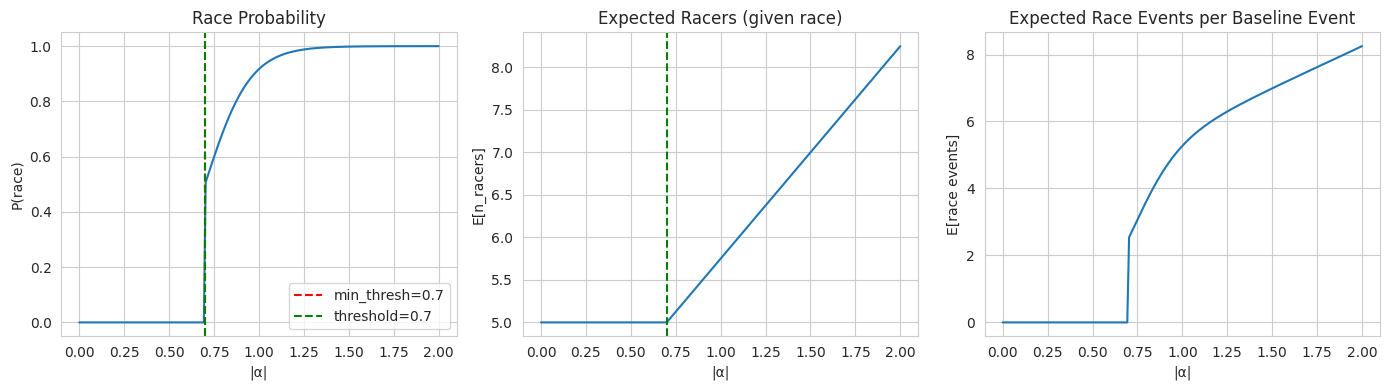

In [91]:
min_threshold = 0.7
threshold = 0.7
steepness = 8.0
base_mean = 5
racer_scale = 2.5

alpha_range = np.linspace(0, 2, 200)
abs_alpha = alpha_range

# Race probability
p_race = np.where(
  abs_alpha < min_threshold,
  0.0,
  1 / (1 + np.exp(-steepness * (abs_alpha - threshold)))
)

# Expected number of racers (given race happens)
mean_racers = base_mean + racer_scale * np.maximum(0, abs_alpha - threshold)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# P(race | α)
axes[0].plot(alpha_range, p_race)
axes[0].axvline(min_threshold, color='r', ls='--', label=f'min_thresh={min_threshold}')
axes[0].axvline(threshold, color='g', ls='--', label=f'threshold={threshold}')
axes[0].set_xlabel('|α|')
axes[0].set_ylabel('P(race)')
axes[0].set_title('Race Probability')
axes[0].legend()

# E[n_racers | α]
axes[1].plot(alpha_range, mean_racers)
axes[1].axvline(threshold, color='g', ls='--')
axes[1].set_xlabel('|α|')
axes[1].set_ylabel('E[n_racers]')
axes[1].set_title('Expected Racers (given race)')

# Combined: E[n_racers] × P(race)
axes[2].plot(alpha_range, p_race * mean_racers)
axes[2].set_xlabel('|α|')
axes[2].set_ylabel('E[race events]')
axes[2].set_title('Expected Race Events per Baseline Event')

plt.tight_layout()

In [92]:
df = pl.read_parquet("/home/labcmap/saad.souilmi/dev_cpp/qr/data/results/PFE/hft_alpha_results/595ce109.parquet")
df = df.filter(~pl.col("rejected"))

In [93]:
dt = df.select(pl.col("ts_event").diff()).drop_nulls().filter(pl.col("ts_event").gt(0))["ts_event"].log10()

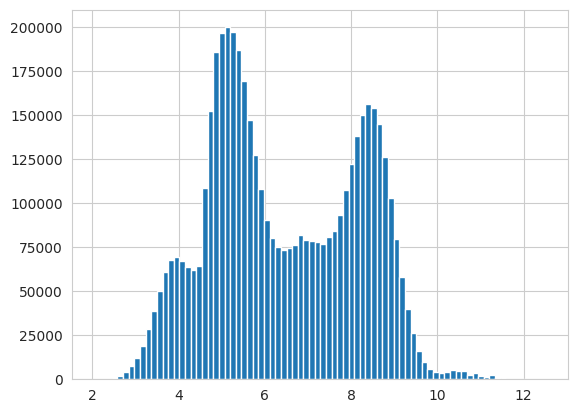

In [94]:
plt.hist(dt, bins=80);

In [95]:
df.filter(pl.col("source").eq(1))["event"].value_counts(normalize=True)

event,proportion
str,f64
"""Cancel""",0.258505
"""Trade""",0.603688
"""Add""",0.137807


In [96]:
df.filter(pl.col("source").eq(1))["event_side"].value_counts(normalize=True)

event_side,proportion
i8,f64
1,0.504579
-1,0.495421


In [97]:
df["source"].value_counts(normalize=True)

source,proportion
i8,f64
0,0.819461
1,0.180539


In [98]:
df

sequence,P_-1,Q_-1,P_1,Q_1,P_-2,Q_-2,P_2,Q_2,imb,mid,ts_event,event,event_side,price,event_size,rejected,partial,bias,alpha,source
i64,i32,i32,i32,i32,i32,i32,i32,i32,f64,f64,i64,str,i8,i32,i32,bool,bool,f64,f64,i8
0,14999,5,15000,6,14998,0,15001,0,-0.090909,14999.5,264832638,"""Add""",1,15000,5,false,false,0.11339,-0.11339,0
1,14999,5,15000,11,14998,0,15001,0,-0.375,14999.5,264906364,"""Add""",-1,14999,1,false,false,0.398036,-0.398036,0
2,14999,6,15000,11,14998,0,15001,0,-0.294118,14999.5,377059869,"""Cancel""",-1,14999,1,false,false,0.314525,-0.314525,0
3,14999,5,15000,11,14998,0,15001,0,-0.375,14999.5,481431707,"""Cancel""",1,15000,2,false,false,0.384615,-0.384615,0
4,14999,5,15000,9,14998,0,15001,0,-0.285714,14999.5,563248748,"""Cancel""",-1,14999,1,false,false,0.335569,-0.335569,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
6341901,15341,5,15343,31,15340,0,15344,0,-0.722222,15342.0,3599982450263841,"""Add""",1,15341,10,false,true,1.705231,-1.705231,1
6341923,15340,9,15341,10,15339,0,15342,0,-0.052632,15340.5,3599982553794666,"""Cancel""",-1,15340,2,false,false,1.003275,-1.003275,1
6341924,15340,7,15341,10,15339,0,15342,0,-0.176471,15340.5,3599982553796405,"""Trade""",-1,15340,2,false,false,1.003275,-1.003275,1


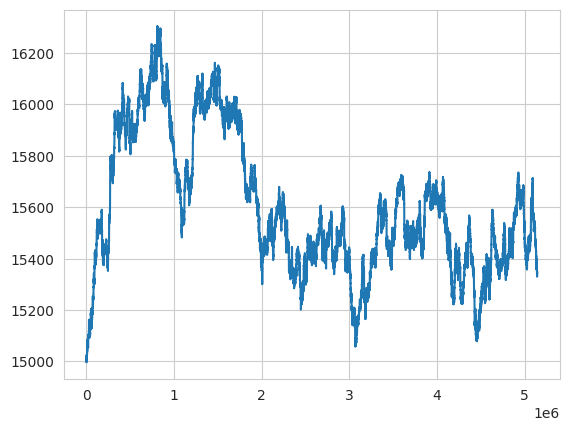

In [99]:
plt.plot(df["P_1"])

plt.show()

mean(α): 0.0036
std(α): 0.5675
mean(|α|): 0.4355
|α| 50th percentile: 0.3467
|α| 75th percentile: 0.6015
|α| 85th percentile: 0.7806
|α| 90th percentile: 0.9243
|α| 95th percentile: 1.1739
mean(α | imb > 0): 0.1842
mean(α | imb < 0): -0.1704


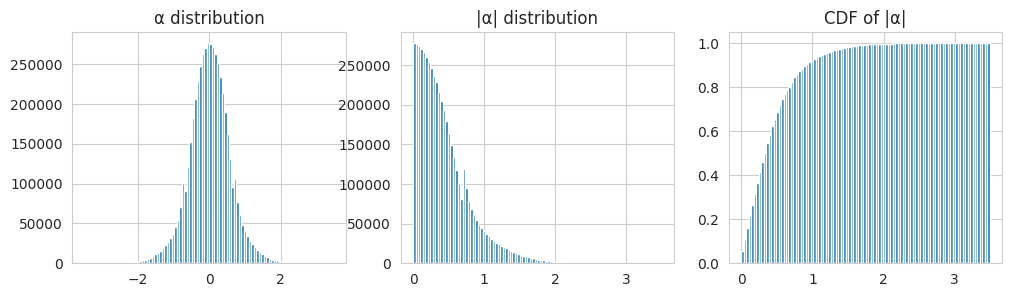

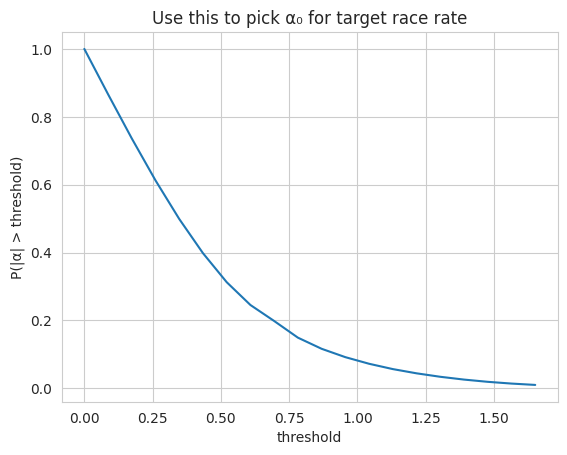

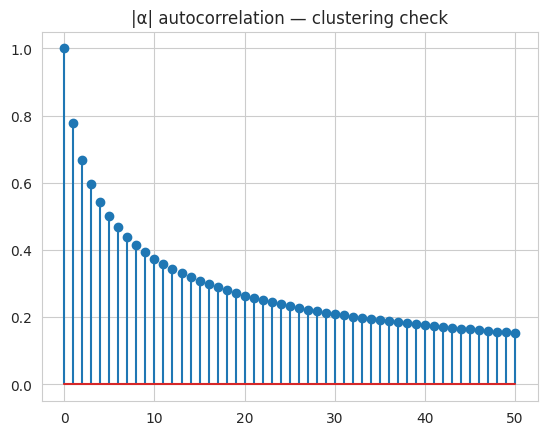

In [100]:
imb = df["imb"].to_numpy()
alpha = df["alpha"].to_numpy()
alpha_abs = np.abs(alpha)

# 1. Basic stats
print(f"mean(α): {np.mean(alpha):.4f}")
print(f"std(α): {np.std(alpha):.4f}")
print(f"mean(|α|): {np.mean(alpha_abs):.4f}")

# 2. Quantiles of |α| — directly gives threshold candidates
for q in [50, 75, 85, 90, 95]:
    print(f"|α| {q}th percentile: {np.percentile(alpha_abs, q):.4f}")

# 3. Distribution shape
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
axes[0].hist(alpha, bins=100)
axes[0].set_title("α distribution")
axes[1].hist(alpha_abs, bins=100)
axes[1].set_title("|α| distribution")
axes[2].hist(alpha_abs, bins=100, cumulative=True, density=True)
axes[2].set_title("CDF of |α|")

# 4. Exceedance rates — what % of events exceed threshold?
thresholds = np.linspace(0, np.percentile(alpha_abs, 99), 20)
exceedance = [np.mean(alpha_abs > t) for t in thresholds]
plt.figure()
plt.plot(thresholds, exceedance)
plt.xlabel("threshold")
plt.ylabel("P(|α| > threshold)")
plt.title("Use this to pick α₀ for target race rate")

# 5. Autocorrelation — do high |α| events cluster?
from statsmodels.tsa.stattools import acf

lag_acf = acf(alpha_abs, nlags=50)
plt.figure()
plt.stem(lag_acf)
plt.title("|α| autocorrelation — clustering check")

# 6. Conditional on imbalance sign — sanity check
print(f"mean(α | imb > 0): {np.mean(alpha[imb > 0]):.4f}")
print(f"mean(α | imb < 0): {np.mean(alpha[imb < 0]):.4f}")